In [1]:
!pip install boruta
!pip install shap
!pip install imblearn

In [2]:
import pandas as pd
import numpy as np
import sklearn
from numpy import float16, mean, std
from sklearn import metrics
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import (
    KFold,
    RepeatedStratifiedKFold,
    cross_val_score,
    train_test_split,
)
import math
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# Load Dataset

file_path = "/Users/Sebastiano/data/ML_MRI copy.xlsx"
df = pd.read_excel(file_path)

print("N° of patients: {}".format(len(df)))
print("N° of columns: {}".format(df.shape[1]))
df.head()

N° of patients: 47
N° of columns: 932


,Patient,Gender,Age,NP-SLE,Event,Scale factor,SNR,White Matter (WM) volume cm3,White Matter (WM) volume %,Normal Appearing White Matter volume cm3,...,FO left thickness mm,FO left thickness norm.,FO thickness asymmetry,PO total thickness mm,PO total thickness norm.,PO right thickness mm,PO right thickness norm.,PO left thickness mm,PO left thickness norm.,PO thickness asymmetry
0,Paziente 1,0,38,1,Mood abnormalities (depressive),0.67586,42.3566,438.3091,35.4223,438.2523,...,2.2623,0.021072,18.2292,2.4475,0.022797,2.2930,0.021358,2.5970,0.024190,-12.4336
1,Paziente 2,0,41,0,Na,0.70729,105.5166,472.6302,37.2214,466.0998,...,1.8574,0.017152,-18.2462,1.3628,0.012585,1.2929,0.011940,1.4317,0.013222,-10.1909
2,Paziente 3,0,32,0,Na,0.65236,49.4839,407.0018,33.7657,406.9770,...,2.6216,0.024634,6.8561,2.3106,0.021711,2.4840,0.023341,2.1159,0.019882,16.0040
3,Paziente 4,0,31,1,Seizure,0.65564,44.8080,424.9121,35.6460,424.8701,...,3.0341,0.028616,-6.5858,2.1641,0.020410,2.2997,0.021689,2.0193,0.019045,12.9849
4,Paziente 5,0,43,0,Na,0.76373,94.5834,548.5729,41.4234,547.8604,...,3.9152,0.035652,-10.4521,2.5960,0.023640,2.5593,0.023305,2.6209,0.023866,-2.3788


In [4]:
# Drop unwanted columns

df = df.drop(['Patient', 'Gender', 'Age','Event', 'Scale factor', 'SNR'], axis = 'columns')
# drop columns that include "%" in their name
#cols_to_drop = [col for col in df.columns if "%" in col]
#df = df.drop(columns=cols_to_drop)
print("Effective features to consider: {} ".format(len(df.columns)-1))

Effective features to consider: 925 


In [5]:
from sklearn.preprocessing import MinMaxScaler

features_to_normalize = df.columns.difference(['NP-SLE'])  # Assuming 'target' is the column to predict

# Normalize the selected features
scaler = MinMaxScaler()
df[features_to_normalize] = scaler.fit_transform(df[features_to_normalize])

In [6]:
import random
random.seed(42)  # Set the random seed to 42 for reproducibility

## Random Forest

In [7]:
def train_test(data: pd.DataFrame):
    
    """Return train-test subjects"""

    np_patients = df.loc[df['NP-SLE'] == 1]
    nonp_patients = df.loc[df['NP-SLE'] == 0]
    hc_patients = df.loc[df['NP-SLE'] == 2]


    print(f"number of neuro patients: {len(np_patients)}")
    print(f"number of non neuro patients: {len(nonp_patients)}")
    print(f"number of non neuro patients: {len(hc_patients)}")


    number_of_train_nonp = math.floor(0.8 * len(nonp_patients))  # = 
    number_of_train_np = math.floor(0.8 * len(np_patients))
    number_of_train_hc = math.floor(0.8 * len(hc_patients))  # = 
    train_nonp = nonp_patients[:number_of_train_nonp]
    train_np = np_patients[:number_of_train_np]
    train_hc = hc_patients[:number_of_train_hc]

    test_nonp = nonp_patients[number_of_train_nonp:]
    test_np = np_patients[number_of_train_np:]
    test_hc = hc_patients[number_of_train_hc:]

    assert len(train_nonp) + len(test_nonp) == len(nonp_patients)
    assert len(train_np) + len(test_np) == len(np_patients)
    assert len(train_hc) + len(test_hc) == len(hc_patients)

    train = pd.concat([train_np, train_nonp, train_hc])
    test = pd.concat([test_np, test_nonp, test_hc])

    return train, test

In [8]:
train, test = train_test(df)
X_train = train.loc[:,:]
X_test = test.loc[:,:]
y_train = train.pop("NP-SLE")
y_test = test.pop("NP-SLE")

clf = RandomForestClassifier(n_estimators=500)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("Accuracy: ", metrics.accuracy_score(y_test, y_pred))

number of neuro patients: 14
number of non neuro patients: 13
number of non neuro patients: 20
Accuracy:  0.8


In [9]:
ConfusionMatrix = metrics.confusion_matrix(y_test, y_pred)
print(ConfusionMatrix)

[[2 1 0]
 [1 2 0]
 [0 0 4]]


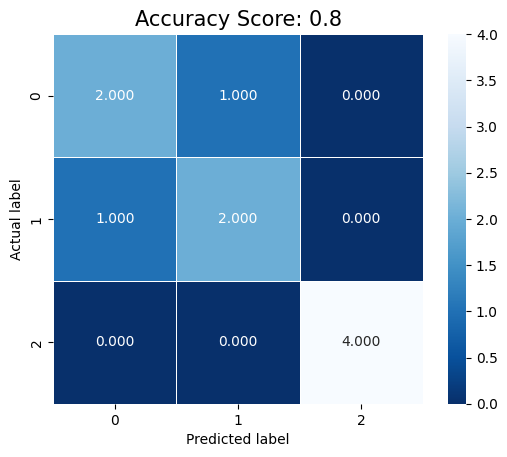

In [10]:
sns.heatmap(ConfusionMatrix, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(metrics.accuracy_score(y_test, y_pred))
plt.title(all_sample_title, size = 15);

## RF_2

In [11]:
target = df['NP-SLE']
inputs = df.drop(['NP-SLE'], axis = 'columns')
x_train, x_test, y_train, y_test = train_test_split(inputs,target,test_size=0.20, random_state=10)

In [12]:
from boruta import BorutaPy
np.int = int  # Override np.int with int

x = x_train.values
y = y_train.values
y = y.ravel()

rf_boruta = RandomForestClassifier(n_jobs=-1, class_weight={0: 1, 1: 3}, max_depth=3)
feat_selector = BorutaPy(rf_boruta, n_estimators='auto', verbose=0, random_state=42, perc=0.3)
feat_selector.fit(x, y)

cols = inputs.columns[feat_selector.support_]
print("N° of selected features: {}".format(len(cols)))
print(cols)


N° of selected features: 628
Index(['White Matter (WM) volume cm3', 'White Matter (WM) volume %',
       'Normal Appearing White Matter volume cm3',
       'Normal Appearing White Matter volume %',
       'Abnormal Appearing White Matter volume cm3',
       'Abnormal Appearing White Matter volume %',
       'Grey Matter (GM) volume cm3', 'Subcortical Grey Matter volume %',
       'Cortical Grey Matter volume cm3', 'Cerebellar Grey Matter volume cm3',
       ...
       'PIns left thickness mm', 'PIns thickness asymmetry',
       'CO left thickness mm', 'CO left thickness norm.',
       'CO thickness asymmetry', 'FO thickness asymmetry',
       'PO right thickness mm', 'PO left thickness mm',
       'PO left thickness norm.', 'PO thickness asymmetry'],
      dtype='object', length=628)


In [13]:
from sklearn.utils.class_weight import compute_class_weight

# Define the class weights based on the training data
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

# Create a dictionary of class weights
class_weight = {i: weight for i, weight in enumerate(class_weights)}

print(class_weight)

{0: 1.121212121212121, 1: 1.121212121212121, 2: 0.8222222222222222}


In [14]:
from sklearn.model_selection import RandomizedSearchCV

# The function to measure the quality of a split
criterion = ['gini', 'entropy']

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start=20, stop=50, num=5)]

# Number of features to consider at every split
max_features = ['sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(14, 30, num=2)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 3, 4, 5, 8]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 3, 4, 5, 6]

max_leaf_nodes = [None, 2, 3, 4, 5, 6]
# Method of selecting samples for training each tree
bootstrap = [True, False]

random_grid = {
    'criterion': criterion,
    'n_estimators': n_estimators,
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
    'max_leaf_nodes': max_leaf_nodes,
    'bootstrap': bootstrap
}

# First create the base model to tune
rf = RandomForestClassifier(
    random_state=42,
    n_jobs=-1,
    class_weight=class_weight
)

# Random search of parameters, using 5 fold cross validation, different combinations, and use all available cores
rf_random = RandomizedSearchCV(
    estimator=rf,
    param_distributions=random_grid,
    n_iter=500,
    cv=5
)

# Fit the random search model
rf_random.fit(x_train, y_train)
rf_random.best_params_

{'n_estimators': 20,
 'min_samples_split': 4,
 'min_samples_leaf': 1,
 'max_leaf_nodes': None,
 'max_features': 'sqrt',
 'max_depth': 14,
 'criterion': 'gini',
 'bootstrap': True}

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_curve, auc, f1_score, recall_score, classification_report
from sklearn.metrics import accuracy_score, precision_score, balanced_accuracy_score


rf = RandomForestClassifier(random_state=20,
                            criterion='gini',
                            n_estimators=20,
                            min_samples_split=4,
                            min_samples_leaf=1,
                            max_leaf_nodes=None,
                            max_features='sqrt',
                            max_depth=14,
                            bootstrap=True)

rf.fit(x_train, y_train)
print("Trained\n")

y_predicted = rf.predict(x_test)
cm_rf = confusion_matrix(y_test, y_predicted)
print(cm_rf, "\n")

print('1. The F-1 Score of the model: {}\n'.format(round(f1_score(y_test, y_predicted, average='macro'), 2)))
print('2. The Recall Score of the model: {}\n'.format(round(recall_score(y_test, y_predicted, average='macro'), 2)))
print('3. Classification report:\n{}\n'.format(classification_report(y_test, y_predicted)))

accuracy = accuracy_score(y_test, y_predicted)
print('Accuracy:', accuracy)

f1 = f1_score(y_test, y_predicted, average='macro')  # 'macro' computes the unweighted mean of F1 scores
print('F1-Score:', f1)

recall = recall_score(y_test, y_predicted, average='macro')
print('Recall:', recall)

precision = precision_score(y_test, y_predicted, average='macro')
print('Precision:', precision)

balanced_accuracy = balanced_accuracy_score(y_test, y_predicted)
print('Balanced Accuracy:', balanced_accuracy)

cm = confusion_matrix(y_test, y_predicted)
print('Confusion Matrix:\n', cm)

report = classification_report(y_test, y_predicted)
print('Classification Report:\n', report)


Trained

[[2 0 0]
 [2 1 0]
 [0 0 5]] 

1. The F-1 Score of the model: 0.72

2. The Recall Score of the model: 0.78

3. Classification report:
              precision    recall  f1-score   support

           0       0.50      1.00      0.67         2
           1       1.00      0.33      0.50         3
           2       1.00      1.00      1.00         5

    accuracy                           0.80        10
   macro avg       0.83      0.78      0.72        10
weighted avg       0.90      0.80      0.78        10


Accuracy: 0.8
F1-Score: 0.7222222222222222
Recall: 0.7777777777777777
Precision: 0.8333333333333334
Balanced Accuracy: 0.7777777777777777
Confusion Matrix:
 [[2 0 0]
 [2 1 0]
 [0 0 5]]
Classification Report:
               precision    recall  f1-score   support

           0       0.50      1.00      0.67         2
           1       1.00      0.33      0.50         3
           2       1.00      1.00      1.00         5

    accuracy                           0.80      

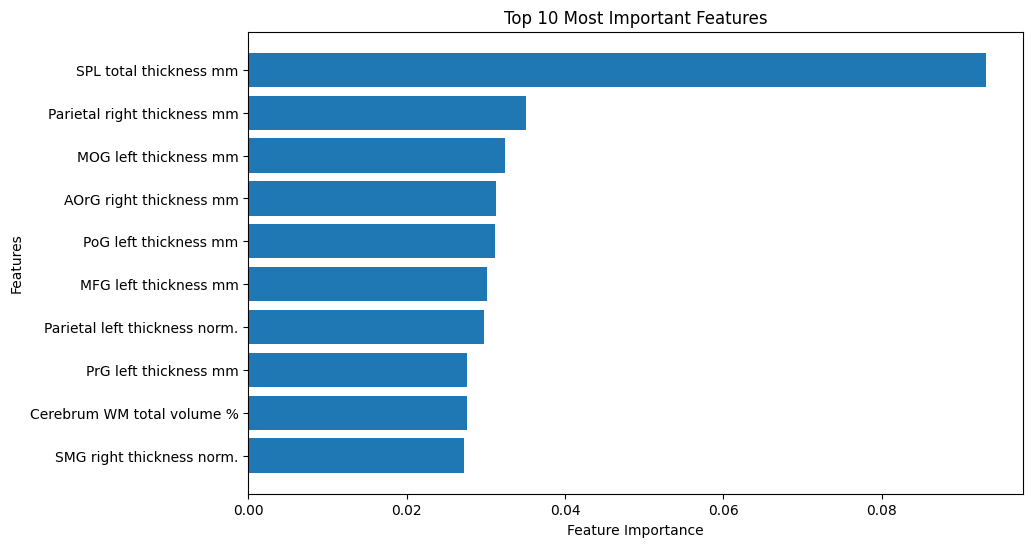

In [17]:
# Get the feature importances
importances = rf.feature_importances_

# Get the indices of the top 10 most important features
top_indices = np.argsort(importances)[-10:]

# Get the names of the top 10 most important features
top_features = inputs.columns[top_indices]

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(range(len(top_features)), importances[top_indices], align='center')
plt.yticks(range(len(top_features)), top_features)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Top 10 Most Important Features')
plt.show()

## RF_3

In [18]:
target = df['NP-SLE']
inputs = df.drop(['NP-SLE'], axis = 'columns')
x_train, x_test, y_train, y_test = train_test_split(inputs,target,test_size=0.20, random_state=10)

In [20]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import LeaveOneOut, KFold
from sklearn.metrics import mean_squared_error

# Define the values for l1_ratio and alphas
l1_ratios = [0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1.0]
alphas = np.linspace(0.2, 1.0, num=20)

# Initialize lists to store the feature importances
feature_importances_loo = []
feature_importances_loo10 = []

max_iter = 10000

# Perform leave-one-out cross-validation
loo = LeaveOneOut()
for train_index, test_index in loo.split(inputs):  # Use inputs instead of df
    x_train, x_test = inputs.iloc[train_index], inputs.iloc[test_index]
    y_train, y_test = target.iloc[train_index], target.iloc[test_index]

    # Train the Elastic Net model for different l1_ratio and alphas
    feature_importance = []
    for l1_ratio in l1_ratios:
        for alpha in alphas:
            elastic_net = ElasticNet(l1_ratio=l1_ratio, alpha=alpha, max_iter=max_iter)
            elastic_net.fit(x_train, y_train)
            y_pred = elastic_net.predict(x_test)
            mse = mean_squared_error(y_test, y_pred)
            feature_importance.append(mse)

    # Store the feature importances for leave-one-out CV
    feature_importances_loo.append(feature_importance)

# Perform leave-10-out cross-validation
kfold = KFold(n_splits=10)
for train_index, test_index in kfold.split(inputs):  # Use inputs instead of df
    x_train, x_test = inputs.iloc[train_index], inputs.iloc[test_index]
    y_train, y_test = target.iloc[train_index], target.iloc[test_index]

    # Train the Elastic Net model for different l1_ratio and alphas
    feature_importance = []
    for l1_ratio in l1_ratios:
        for alpha in alphas:
            elastic_net = ElasticNet(l1_ratio=l1_ratio, alpha=alpha, max_iter=max_iter)
            elastic_net.fit(x_train, y_train)
            y_pred = elastic_net.predict(x_test)
            mse = mean_squared_error(y_test, y_pred)
            feature_importance.append(mse)

    # Store the feature importances for leave-10-out CV
    feature_importances_loo10.append(feature_importance)

# Compute the average feature importance across cross-validation folds
avg_importance_loo = np.mean(feature_importances_loo, axis=0)
avg_importance_loo10 = np.mean(feature_importances_loo10, axis=0)

# Find the indices of the top 10 most important features
top_indices_loo = np.argsort(avg_importance_loo)[:10]
top_indices_loo10 = np.argsort(avg_importance_loo10)[:10]

# Get the feature names of the top 10 most important features
top_features_loo = inputs.columns[top_indices_loo]
top_features_loo10 = inputs.columns[top_indices_loo10]

# Print the top 10 features for leave-one-out CV
print("Top 10 features for leave-one-out CV:")
for i, feature in enumerate(top_features_loo):
    print(f"{i+1}. {feature}")

# Print the top 10 features for leave-10-out CV
print("\nTop 10 features for leave-10-out CV:")
for i, feature in enumerate(top_features_loo10):
    print(f"{i+1}. {feature}")

Top 10 features for leave-one-out CV:
1. White Matter (WM) volume cm3
2. White Matter (WM) volume %
3. Normal Appearing White Matter volume cm3
4. Normal Appearing White Matter volume %
5. Abnormal Appearing White Matter volume cm3
6. Abnormal Appearing White Matter volume %
7. Grey Matter (GM) volume cm3
8. Grey Matter (GM) volume %
9. Subcortical Grey Matter volume cm3
10. Subcortical Grey Matter volume %

Top 10 features for leave-10-out CV:
1. White Matter (WM) volume cm3
2. White Matter (WM) volume %
3. Normal Appearing White Matter volume cm3
4. Normal Appearing White Matter volume %
5. Abnormal Appearing White Matter volume cm3
6. Abnormal Appearing White Matter volume %
7. Grey Matter (GM) volume cm3
8. Grey Matter (GM) volume %
9. Subcortical Grey Matter volume cm3
10. Subcortical Grey Matter volume %


In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, classification_report
from sklearn.model_selection import LeaveOneOut

# Initialize lists to store the results
actual_labels = []
predicted_labels = []

# Perform nested LOO cross-validation
loo = LeaveOneOut()
for train_index, test_index in loo.split(inputs):
    # Prepare the training and testing data
    x_train, x_test = inputs.iloc[train_index], inputs.iloc[test_index]
    y_train, y_test = target.iloc[train_index], target.iloc[test_index]
    
    # Train the random forest model
    rf = RandomForestClassifier(random_state=42)
    rf.fit(x_train, y_train)
    
    # Predict class labels for the test subject
    y_pred = rf.predict(x_test)
    
    # Append the actual label and predicted labels to the lists
    actual_labels.extend(y_test)
    predicted_labels.extend(y_pred)

# Calculate performance metrics
accuracy = accuracy_score(actual_labels, predicted_labels)
report = classification_report(actual_labels, predicted_labels)

# Print the results
print("Accuracy:", accuracy)
print("Classification Report:\n", report)


Accuracy: 0.7872340425531915
Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.46      0.55        13
           1       0.65      0.79      0.71        14
           2       0.95      1.00      0.98        20

    accuracy                           0.79        47
   macro avg       0.76      0.75      0.74        47
weighted avg       0.78      0.79      0.78        47



In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import LeaveOneOut, KFold
import numpy as np

# Initialize lists to store results for each repetition
accuracies = []
precision_list = []
recall_list = []
f1_score_list = []

# Repeat the process 100 times
for _ in range(100):
    # Initialize lists to store results for each fold
    fold_actual_labels = []
    fold_predicted_labels = []

    # Perform nested Leave-10-Out cross-validation
    kfold = KFold(n_splits=10, shuffle=True, random_state=None)
    for train_index, test_index in kfold.split(df):
        x_train, x_test = inputs.iloc[train_index], inputs.iloc[test_index]
        y_train, y_test = target.iloc[train_index], target.iloc[test_index]

        # Train the random forest model
        rf = RandomForestClassifier(random_state=42)
        rf.fit(x_train, y_train)

        # Predict class labels for the test subjects
        y_pred = rf.predict(x_test)

        # Append the actual and predicted labels to the lists for this fold
        fold_actual_labels.extend(y_test)
        fold_predicted_labels.extend(y_pred)

    # Calculate performance metrics for this repetition
    accuracy = accuracy_score(fold_actual_labels, fold_predicted_labels)
    classification_report_str = classification_report(fold_actual_labels, fold_predicted_labels, output_dict=True)

    # Store results for this repetition
    accuracies.append(accuracy)
    precision_list.append(classification_report_str['macro avg']['precision'])
    recall_list.append(classification_report_str['macro avg']['recall'])
    f1_score_list.append(classification_report_str['macro avg']['f1-score'])

# Calculate the average accuracy and classification report over 100 repetitions
average_accuracy = np.mean(accuracies)
average_precision = np.mean(precision_list)
average_recall = np.mean(recall_list)
average_f1_score = np.mean(f1_score_list)

# Compute 95% confidence intervals using the percentile method
confidence_interval_lower = np.percentile(accuracies, 2.5)
confidence_interval_upper = np.percentile(accuracies, 97.5)

# Print the summary results
print(f"Average Accuracy: {average_accuracy}")
print(f"Confidence Interval: [{confidence_interval_lower}, {confidence_interval_upper}]")
print(f"Average Precision: {average_precision}")
print(f"Average Recall: {average_recall}")
print(f"Average F1-Score: {average_f1_score}")


Average Accuracy: 0.7095744680851065
Confidence Interval: [0.6170212765957447, 0.7872340425531915]
Average Precision: 0.6586009731009732
Average Recall: 0.6619597069597069
Average F1-Score: 0.6579480864649847


In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import LeaveOneOut, KFold
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectFromModel
import numpy as np

# Initialize lists to store the results
accuracies_loo = []
accuracies_loo10 = []

# Perform leave-one-out cross-validation
loo = LeaveOneOut()
for train_index, test_index in loo.split(df):
    x_train, x_test = inputs.iloc[train_index], inputs.iloc[test_index]
    y_train, y_test = target.iloc[train_index], target.iloc[test_index]
    
    # Train the Elastic Net model for feature selection
    elastic_net = ElasticNet(l1_ratio=0.5, alpha=0.5, max_iter=10000)
    elastic_net.fit(x_train, y_train)
    
    # Select features based on Elastic Net feature importances
    sfm = SelectFromModel(elastic_net)
    sfm.fit(x_train, y_train)
    
    # Transform the datasets to include only selected features
    x_train_selected = sfm.transform(x_train)
    x_test_selected = sfm.transform(x_test)
    
    # Train the RandomForestClassifier on the selected features
    rf = RandomForestClassifier(random_state=42)
    rf.fit(x_train_selected, y_train)
    
    # Predict class labels for the test subjects
    y_pred = rf.predict(x_test_selected)
    
    # Calculate accuracy and store it for leave-one-out CV
    accuracy_loo = accuracy_score(y_test, y_pred)
    accuracies_loo.append(accuracy_loo)

# Perform leave-10-out cross-validation
kfold = KFold(n_splits=10)
for train_index, test_index in kfold.split(df):
    x_train, x_test = inputs.iloc[train_index], inputs.iloc[test_index]
    y_train, y_test = target.iloc[train_index], target.iloc[test_index]
    
    # Train the Elastic Net model for feature selection
    elastic_net = ElasticNet(l1_ratio=0.5, alpha=0.5, max_iter=10000)
    elastic_net.fit(x_train, y_train)
    
    # Select features based on Elastic Net feature importances
    sfm = SelectFromModel(elastic_net)
    sfm.fit(x_train, y_train)
    
    # Transform the datasets to include only selected features
    x_train_selected = sfm.transform(x_train)
    x_test_selected = sfm.transform(x_test)
    
    # Train the RandomForestClassifier on the selected features
    rf = RandomForestClassifier(random_state=42)
    rf.fit(x_train_selected, y_train)
    
    # Predict class labels for the test subjects
    y_pred = rf.predict(x_test_selected)
    
    # Calculate accuracy and store it for leave-10-out CV
    accuracy_loo10 = accuracy_score(y_test, y_pred)
    accuracies_loo10.append(accuracy_loo10)

# Print the average accuracy for leave-one-out CV
average_accuracy_loo = np.mean(accuracies_loo)
print(f"Average Accuracy for leave-one-out CV: {average_accuracy_loo:.4f}")

# Print the average accuracy for leave-10-out CV
average_accuracy_loo10 = np.mean(accuracies_loo10)
print(f"Average Accuracy for leave-10-out CV: {average_accuracy_loo10:.4f}")


Average Accuracy for leave-one-out CV: 0.7872
Average Accuracy for leave-10-out CV: 0.7600


/opt/homebrew/Caskroom/miniforge/base/envs/lupus/lib/python3.10/site-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/opt/homebrew/Caskroom/miniforge/base/envs/lupus/lib/python3.10/site-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit fo

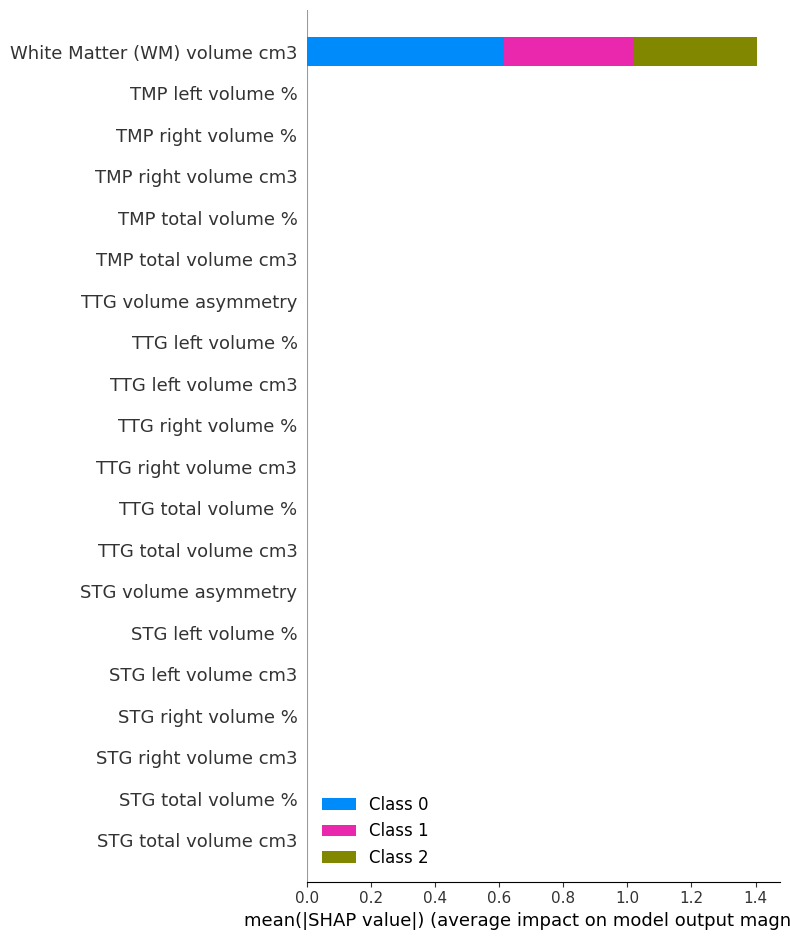

Instance index: 45


IndexError: list index out of range

In [22]:
import shap
import numpy as np
import matplotlib.pyplot as plt

db = df.drop('NP-SLE', axis=1)
# Convert your dataset to a numpy array if it's not already in that format
X_1 = db.to_numpy()

# Initialize the SHAP explainer with your random forest model
explainer = shap.Explainer(rf)

# Compute SHAP values for all instances in the dataset
shap_values = explainer.shap_values(X_1)

# (a) Global feature importance plot
shap.summary_plot(shap_values, db.columns)

# (b) Value-specific feature importance plot
# Select a random instance from the dataset
instance_index = np.random.randint(len(X_1))
print("Instance index:", instance_index)  # Debugging line

# Ensure the instance index is within a valid range
instance_index = min(instance_index, len(X_1) - 1)

shap.force_plot(
    explainer.expected_value,
    shap_values[instance_index],
    db.iloc[instance_index, :],
    feature_names=db.columns
)

# (c) Detailed trend plot
# Select a feature to analyze
feature_index = np.random.randint(len(db.columns))
shap.dependence_plot(
    db.columns[feature_index],
    shap_values,
    db,
    feature_names=db.columns
)

plt.show()


In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as pyplot
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier

RF=OneVsRestClassifier(RandomForestClassifier(max_features=5))
RF.fit(x_train,y_train)
y_pred =RF.predict(x_test)
pred_prob = RF.predict_proba(x_test)